In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, DateType

# Configuração do Spark
spark = (
    SparkSession.builder
    .appName("Azure ML - Spark Session") 
    .getOrCreate()
)
spark

SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/anaconda/envs/azureml_py38/lib/python3.10/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.2.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/anaconda/envs/azureml_py38/lib/python3.10/site-packages/pyspark/jars/log4j-slf4j-impl-2.17.1.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.apache.logging.slf4j.Log4jLoggerFactory]


25/06/10 01:42:34 WARN Utils: Your hostname, fernandabomtorin1 resolves to a loopback address: 127.0.0.1; using 10.0.0.4 instead (on interface eth0)
25/06/10 01:42:34 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


25/06/10 01:42:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
spark.sparkContext.setLogLevel("ERROR")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
spark.stop()

# Extração dos dados e análise exploratória
- Loading dos arquivos parquet, referente as bases de dados do problema
- Base de transações, membros e logs
- Entendimento dos dados disponiveis

In [3]:
# Loading das bases de dados
df_transactions = spark.read.parquet("dados/transactions.parquet")
df_members = spark.read.parquet("dados/members.parquet")
df_logs = spark.read.parquet("dados/user_logs.parquet")

### Base de transações

In [4]:
# Transformação das colunas de data
df_transactions = df_transactions.select(
    F.col('msno'),
    F.col('payment_method_id').cast(DoubleType()),
    F.col('payment_plan_days').cast(DoubleType()),
    F.col('plan_list_price').cast(DoubleType()),
    F.col('actual_amount_paid').cast(DoubleType()),
    F.col('is_auto_renew').cast(IntegerType()),
    F.col('transaction_date'),
    F.col('membership_expire_date'),
    F.col('is_cancel').cast(IntegerType()),
    F.col('safra')
).withColumn(
    'transaction_date',
    F.to_date(F.concat(
                F.col('transaction_date').substr(1, 4),
                F.lit('-'),
                F.col('transaction_date').substr(5, 2),
                F.lit('-'),
                F.col('transaction_date').substr(7, 2)), 'yyyy-MM-dd')
).withColumn(
    'membership_expire_date',
    F.to_date(F.concat(
                F.col('membership_expire_date').substr(1, 4),
                F.lit('-'),
                F.col('membership_expire_date').substr(5, 2),
                F.lit('-'),
                F.col('membership_expire_date').substr(7, 2)), 'yyyy-MM-dd')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
)

In [ ]:
df_transactions.summary().show()

### Base de membros

In [5]:
df_members = df_members.select(
    F.col('msno'),
    F.col('city').cast(IntegerType()),
    F.col('bd').cast(IntegerType()),
    F.col('gender'),
    F.col('registered_via').cast(IntegerType()),
    F.col('registration_init_time'),
    F.col('is_ativo').cast(IntegerType()),
    F.col('safra')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
).withColumn(
    'registration_init_time',
    F.to_date(
        F.concat(
            F.col('registration_init_time').substr(1, 4),
            F.lit('-'),
            F.col('registration_init_time').substr(5, 2),
            F.lit('-'),
            F.col('registration_init_time').substr(7, 2)), 'yyyy-MM-dd')
)

In [ ]:
df_members.summary().show()

### Base logs

In [6]:
df_logs = df_logs.select(
    F.col('msno'),
    F.col('num_25').cast(DoubleType()),
    F.col('num_50').cast(DoubleType()),
    F.col('num_75').cast(DoubleType()),
    F.col('num_985').cast(DoubleType()),
    F.col('num_100').cast(DoubleType()),
    F.col('num_unq').cast(DoubleType()),
    F.col('total_secs').cast(DoubleType()),
    F.col('safra')
).withColumn(
    'safra',
    F.to_date(
        F.concat(
            F.col('safra').substr(1, 4),
            F.lit('-'),
            F.col('safra').substr(5, 2),
            F.lit('-'),
            F.lit('01')), 'yyyy-MM-dd')
)

In [ ]:
df_logs.summary().show()

# O Case
Dados históricos de dois anos de clientes de uma empresa que oferece streaming de musica baseado em assinatura.
Quando os usuários se inscrevem no serviço, eles podem optar por renovar o serviço manualmente ou renovar automaticamente, podendo cancelar ativamente sua associação à qualquer momento.
## Modelo de Churn
Criação de um modelo classificador para prever clientes que serão churn 3 meses no futuro (ou seja, clientes que possuem assinatura ativa no periodo analisado e 3 mses depois desse período ele não esta mais ativo, ou porque cancelou ou não renovou a assinatura) e identifique os clientes que serão direcionados para a ação de forma proativa.

# Definição de público
- Clientes que possuem assinatura ativa, utilizando a base de membros 
- Como a base apresenta safras de todos os meses ao longo de 2016, utiliza-se o público até a safra de 2016-09-01 para que possuam apenas clientes que possamos saber o comportamento 3 meses para a frente

In [ ]:
spine = df_members.filter(
    (F.col('is_ativo') == 1) &
    (F.col('safra') <= F.lit('2016-09-01'))
).dropDuplicates()

# Definição da target
- Churn ou não churns, 3 meses no futuro
- Todas as variaveis sobre o cliente, estão em uma visao 3 meses antes da target
- A partir da spine, com os clientes ativos em cada safra, é feito um cruzamento buscando o cliente na safra 3 meses para o futuro
- Cria-se a variável target, 1 se o cliente estiver ativo, 0 se nao estiver ativo (churn)

In [ ]:
df_members_aliased = df_members.select('msno', 'safra', 'is_ativo').withColumnRenamed('safra', 'safra_target').withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra_target')))
df = spine.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.add_months(F.col('safra'), 3)))
df = df.join(df_members_aliased.select(
    'chave','safra_target', 'is_ativo'
    ).withColumn(
    'target', F.when(F.col('is_ativo') == 1, 0).otherwise(1)
    ).drop('is_ativo'),on='chave', how='left').drop('chave')

**Amostra**

Como se trata de uma base muito extensa, optou-se por realizar uma amostra estratificada utilizando 10% da base, para que garantir que se manter as proporções da target da população.

In [ ]:
# Obtendo uma amostra, mantendo a proporção da target
fractions = {0: 0.2, 1: 0.2}  # Proporção de amostragem para cada classe

df_sample = df.sampleBy("target", fractions, seed=42)

#### *Considerações sobre público e a target*

1.   *Target desbalanceada* -> Há uma quantidade bem maior de clientes que continuaram ativos (1), que os clientes churn. Dessa forma, na hora de criar o modelo, é interessante utilizar pesos para balancear a target.
2.   *Mesmo cliente pode aparecer mais de uma vez na base* -> estamos capturando o comportamente desse cliente no mes, é necessário trazer as features sobre a transação e logs, mostrando o comportamento diferente em cada mes, e como isso impacta na target (se ele será churn ou não)
3.   *Horizonte do público em 2016* -> a target deve ser o cliente ativo ou nao, informação que é possivel de encontrar apenas na base de members, e portanto, temos apenas informações de 2016


# Adição das informações de transações e logs 

#### **Transações:**

*variaveis uteis existentes:*
- is_auto_renew -> seria um indicativo de que o cliente talvez nao renove o plano?
- payment_plan_days -> indicando quanto tempo o cliente tem para renovar o plano
- plan_list_price -> indicando o valor tabelado da assinatura
- actual_amount_paid -> mostrando o quanto o cliente esta pagando, se for muito pode trazer indicios de cancelamento
- membership_expire_date -> transformar em quanto tempo para finalização do plano
- is_canceled -> indicando se o plano foi cancelado ou nao -> pode indicar que o cliente cancelou e no mes seguinte a assinatura nao estara mais ativa



In [ ]:
transactions=df_transactions.filter(F.year(F.col('safra'))=='2016')

In [ ]:
transactions.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).groupBy('chave').count().orderBy(F.desc('count')).show(5)

_Apenas uma transação mensal_ 

In [ ]:
df_sample = df_sample.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra')))
df_sample = df_sample.join(transactions.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).select('chave', 'is_auto_renew', 'payment_plan_days', 'plan_list_price','actual_amount_paid', 'membership_expire_date', 'is_cancel'),
                     on='chave', how='left')

#### **Logs:**
Utilizar a ultima data do mês para buscar as estatisticas sobre o uso, porque dessa forma é possível compreender como foi o comportamento do cliente ao longo do mês com o uso da plataforma.

*variáveis:*
1. num_25
2. num_50
3. num_75
4. num_985
5. num_100
6. num_unq
7. total_secs

In [ ]:
logs=df_logs.filter(F.year(F.col('safra'))=='2016')

In [ ]:
logs.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).groupBy('chave').count().orderBy(F.desc('count')).show(5)

_Apenas uma informação de log mensal_ 

In [ ]:
df_sample = df_sample.join(logs.withColumn('chave', F.concat(F.col('msno'), F.lit('_'), F.col('safra'))).select('chave', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs'),
                     on='chave', how='left')

In [ ]:
# Salvando a amostra em formato CSV
output_csv_path = "dados/amostra.csv"
df_sample.toPandas().to_csv(output_csv_path, index=False)

# Análise da target
- Distribuição da target na amostra selecionada 
- Analise da target ao longo das safras

In [7]:
data = pd.read_csv("dados/amostra.csv")

/tmp/ipykernel_3799/82669921.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='target', data=data, palette=["#000000A6", "#970000AA"])


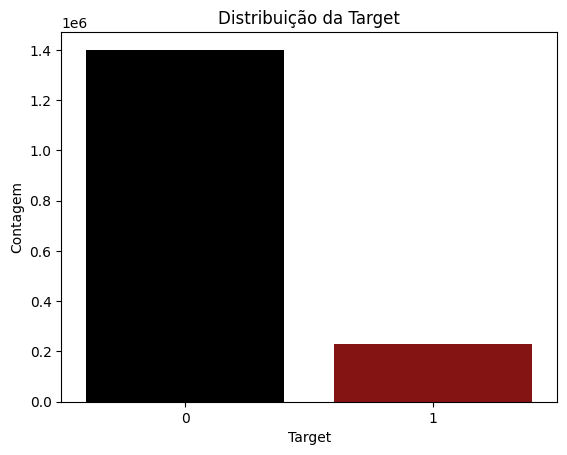

In [8]:
# Distribuição da target
sns.countplot(x='target', data=data, palette=["#000000A6", "#970000AA"])
plt.title('Distribuição da Target')
plt.xlabel('Target')
plt.ylabel('Contagem')
plt.show()

In [9]:
percentual_churn = data.groupby('safra')['target'].mean().reset_index()
percentual_churn.columns = ['safra', 'percentual_churn']
percentual_churn['percentual_churn'] = round(percentual_churn['percentual_churn'] * 100, 2)
mean_churn = percentual_churn['percentual_churn'].mean()

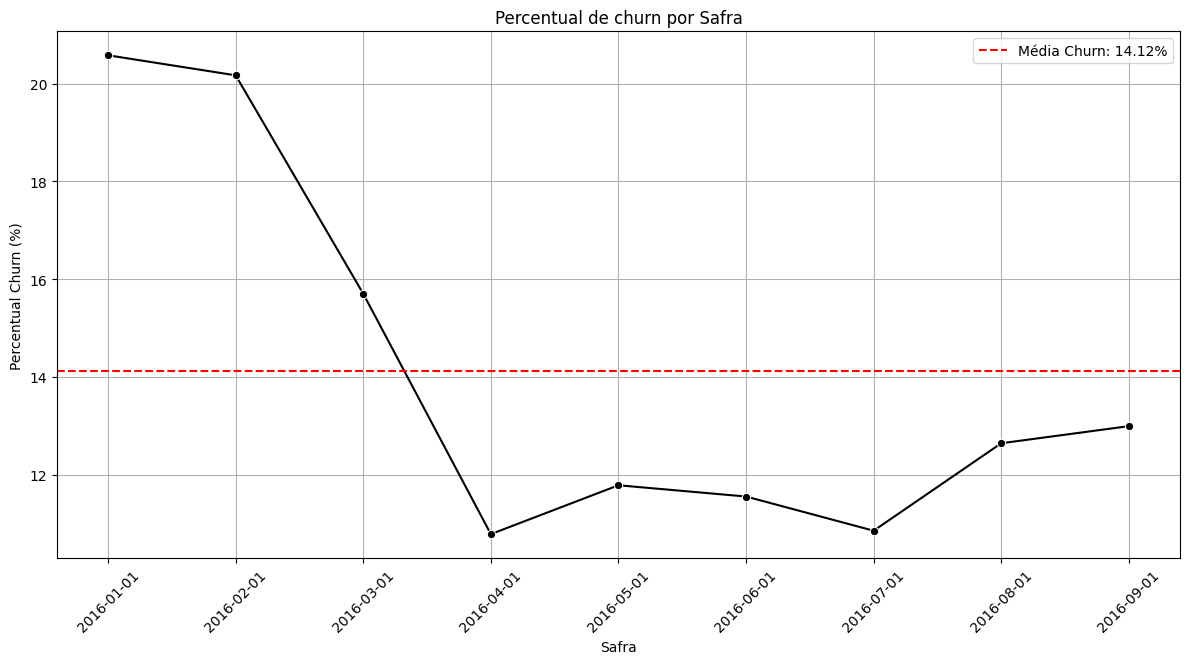

In [10]:
# Analise temporal da variável target
plt.figure(figsize=(12, 6))
sns.lineplot(data=percentual_churn,x='safra', y='percentual_churn', marker='o', color="#000000")
plt.axhline(mean_churn, color='red', linestyle='--', label=f'Média Churn: {mean_churn:.2f}%')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel('Safra')
plt.ylabel('Percentual Churn (%)')
plt.title('Percentual de churn por Safra')
plt.xticks(rotation=45)
plt.show()

# Analise das variáveis e data-prep
















## Separação das bases de treino, teste, validação e oot 
- Não serão utilizadas as safras 2016-01-01, 2016-02-01 e 2016-03-01 para o desenvolvimento do modelo, por apresentarem alto percentual de churn, destoando dos outros meses 
- **Treino e teste**: 90% treino e teste, utilizando as safras de 2016-03-01 á 2016-08-01, separados depois em 80% pra treino e 20% teste
- **Validacao**: 10% da base, utilizando as safras de 2016-03-01 á 2016-08-01 
- **OOT**: 100% da base na safra em 2016-09-01

In [11]:
data.groupby('safra').count()['msno']

safra
2016-01-01    177483
2016-02-01    183729
2016-03-01    173981
2016-04-01    166497
2016-05-01    170585
2016-06-01    169320
2016-07-01    194059
2016-08-01    196687
2016-09-01    198323
Name: msno, dtype: int64

In [12]:
amostra_treino_validacao = (data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])][["msno"]].drop_duplicates().sample(frac = 0.8, random_state = 42, replace = False))

train = (amostra_treino_validacao.sample(frac = 0.9, random_state = 42, replace = False)[["msno"]].drop_duplicates()) 

valid = (amostra_treino_validacao.loc[~amostra_treino_validacao["msno"].isin(list(train["msno"].unique()))][["msno"]].drop_duplicates())

test = (data.loc[
            (data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])) & 
            (~data["msno"].isin(list(train["msno"].unique()))) & 
            (~data["msno"].isin(list(valid["msno"].unique())))][["msno"]].drop_duplicates()
)

oot = (data.loc[(data["safra"].isin(["2016-09-01"]))][["msno"]].drop_duplicates())

train = train.merge(data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])], on = "msno", how = "left")
valid = valid.merge(data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])], on = "msno", how = "left")
test = test.merge(data.loc[data["safra"].isin(["2016-04-01", "2016-05-01", "2016-06-01", "2016-07-01", "2016-08-01"])], on = "msno", how = "left")
oot = oot.merge(data.loc[data["safra"].isin(["2016-09-01"])], on = "msno", how = "left")

In [13]:
print('Total treino: ', train.count()['msno'])
print('Total teste: ', test.count()['msno'])
print('Total validação: ', valid.count()['msno'])
print('Total OOT: ', oot.count()['msno'])

Total treino:  645813
Total teste:  179762
Total validação:  71573
Total OOT:  198323


/tmp/ipykernel_3799/2384464509.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


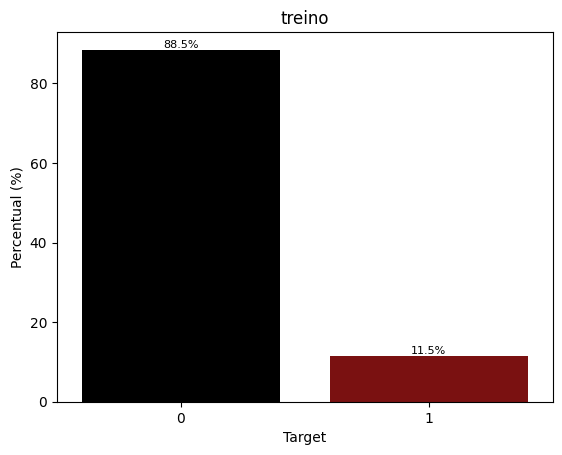

/tmp/ipykernel_3799/2384464509.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


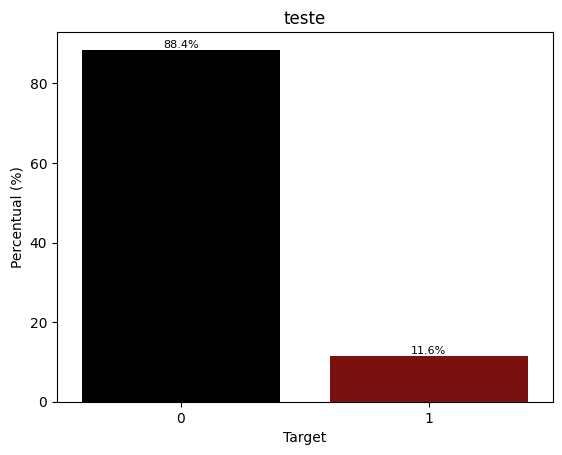

/tmp/ipykernel_3799/2384464509.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


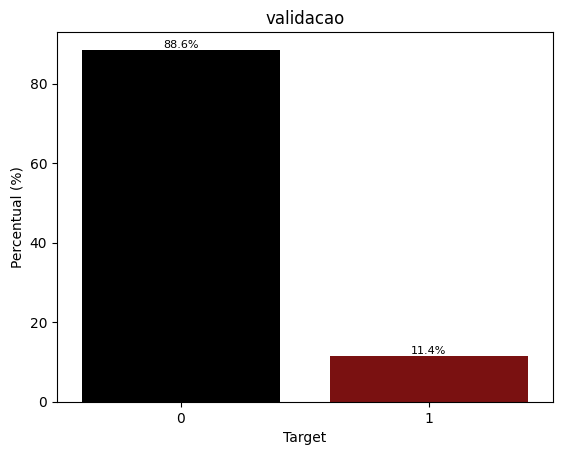

/tmp/ipykernel_3799/2384464509.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)


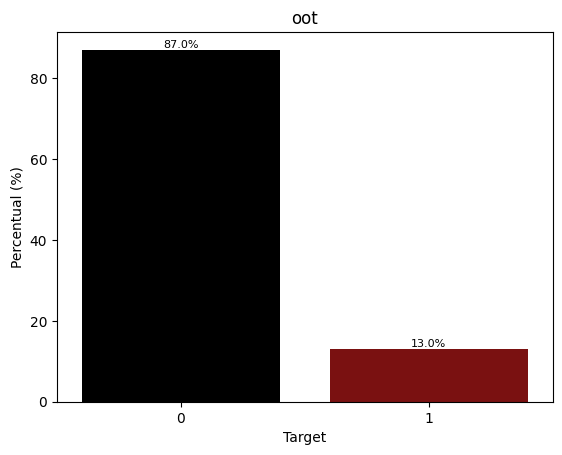

In [14]:
def contagem(df):
    return df.groupby('target', as_index=False).count().rename(columns={'msno': 'count'}).assign(perc=lambda x: x['count'] / x['count'].sum() * 100)

def plot_churn(df, name):
    custom_palette = ["#000000", "#8B0000"]
    data_plot = contagem(df)
    ax = sns.barplot(data=data_plot, x='target', y='perc', label=name, palette=custom_palette)
    plt.xlabel('Target')
    plt.ylabel('Percentual (%)')
    plt.title(name)

    # Adiciona o rótulo em cada barra
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=8, color='black')

    plt.show()  

plot_churn(train, 'treino')
plot_churn(test, 'teste')
plot_churn(valid, 'validacao')
plot_churn(oot, 'oot')


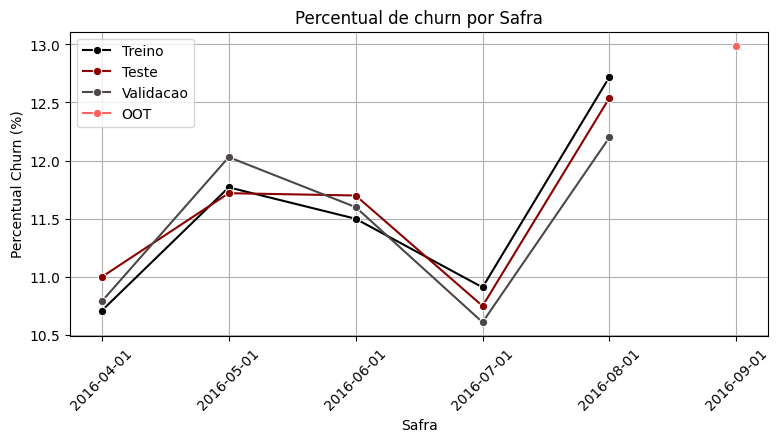

In [15]:
def perc_churn(df, name):
    """
    Função para calcular o percentual de churn em um DataFrame.
    """
    aux = df.groupby('safra')['target'].mean().reset_index()
    aux.columns = ['safra', f'percentual_churn_{name}']
    aux[f'percentual_churn_{name}'] = round(aux[f'percentual_churn_{name}'] * 100, 2)
    return aux

# Calculando o percentual de churn para cada conjunto de dados
train_churn = perc_churn(train, 'treino')
test_churn = perc_churn(test, 'teste')
valid_churn = perc_churn(valid, 'validacao')
oot_churn = perc_churn(oot, 'oot')

# Analise temporal da variável target
plt.figure(figsize=(8, 4))
sns.lineplot(data=train_churn,x='safra', y='percentual_churn_treino', marker='o', label='Treino', color="#000000")
sns.lineplot(data=test_churn,x='safra', y='percentual_churn_teste', marker='o', label='Teste', color="#8B0000")
sns.lineplot(data=valid_churn,x='safra', y='percentual_churn_validacao', marker='o', label='Validacao', color="#4D4747")
sns.lineplot(data=oot_churn,x='safra', y='percentual_churn_oot', marker='o', label='OOT',   color="#FF6161")
plt.xlabel('Safra')
plt.ylabel('Percentual Churn (%)')
plt.title('Percentual de churn por Safra')
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Análise das variáveis 

**Valores missing**

In [16]:
null_counts = train.isnull().sum()
null_percent = (null_counts / len(data)) * 100
null_summary = pd.DataFrame({'null_count': null_counts, 'null_percent': null_percent.round(2)})
null_summary

,null_count,null_percent
msno,0,0.00
chave,0,0.00
city,0,0.00
bd,0,0.00
gender,313788,19.24
registered_via,0,0.00
registration_init_time,0,0.00
is_ativo,0,0.00
safra,0,0.00
safra_target,0,0.00


In [17]:
# Separação das features categorias e numericas
cat_cols = ['city', 'gender', 'registered_via', 'is_auto_renew','is_cancel']
num_cols = ['bd', 'payment_plan_days', 'actual_amount_paid', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs']

**Variáveis categóricas**

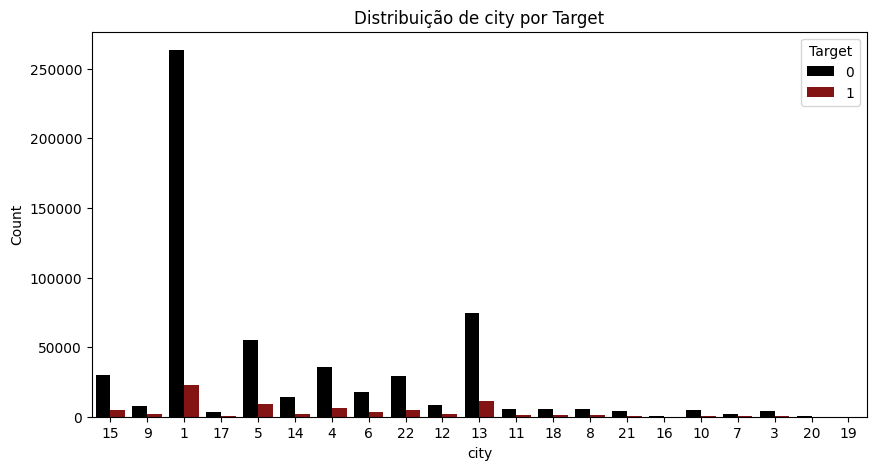

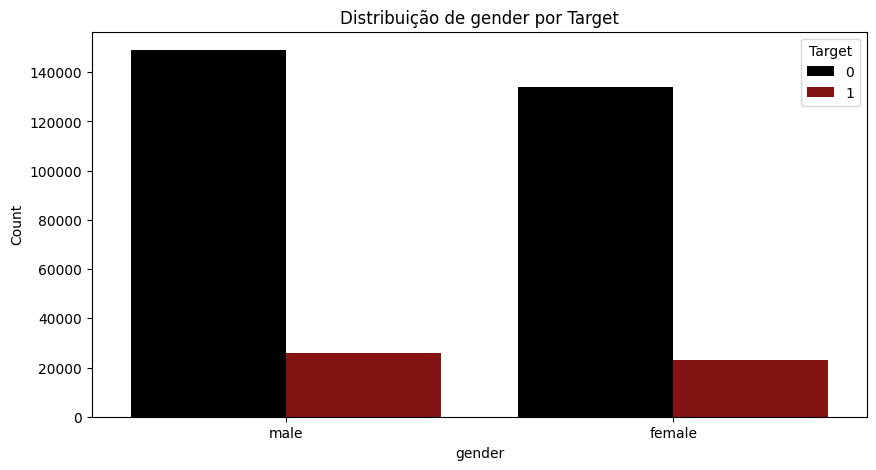

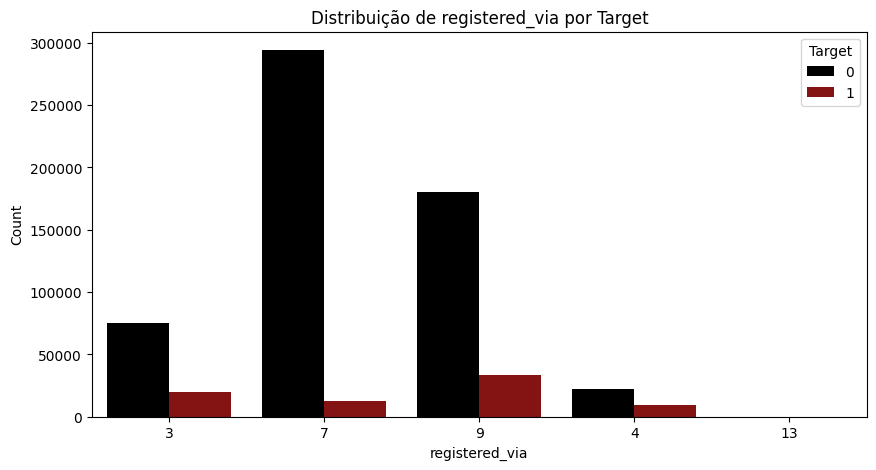

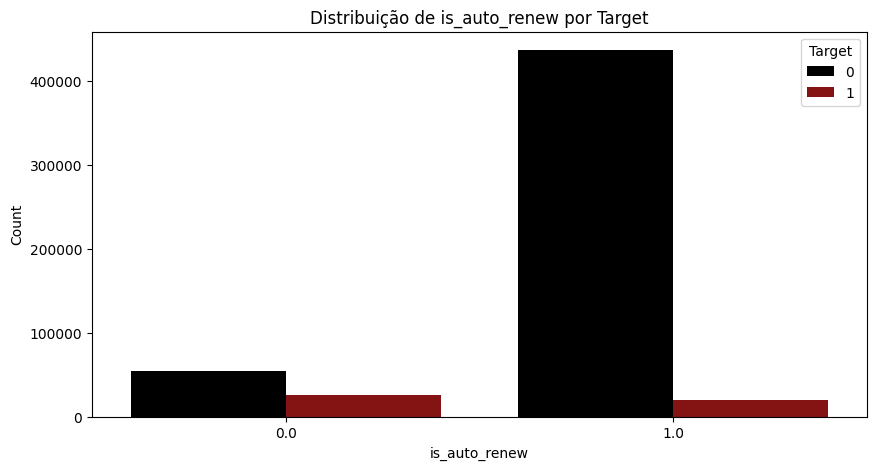

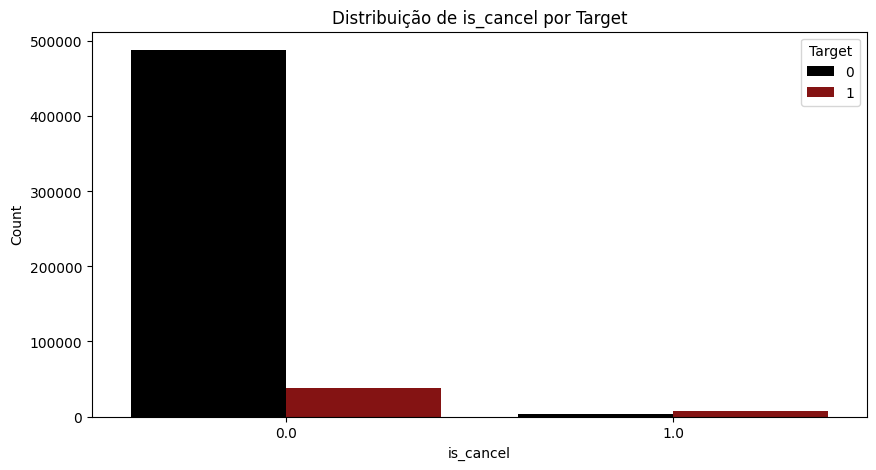

In [18]:
for i in cat_cols:
  train[i] = train[i].astype('string')
  plt.figure(figsize=(10, 5))
  sns.countplot(data=train, x=i, hue='target', palette=["#000000A6", "#970000AA"])
  plt.title(f'Distribuição de {i} por Target')
  plt.xlabel(i)
  plt.ylabel('Count')
  plt.legend(title='Target', loc='upper right')
  plt.show()

In [19]:
for i in cat_cols:
    display(train.groupby(i)[['target']].mean().assign(target=lambda x: round(x['target'] * 100, 2)).rename(columns={'target': 'percentual_churn'}).sort_values('percentual_churn', ascending=False).T)

city,9,19,21,12,10,22,20,15,11,6,18,4,5,8,17,3,14,13,16,7,1
percentual_churn,21.44,17.92,16.35,16.2,15.18,14.85,14.66,14.66,14.61,14.53,14.48,14.43,14.26,14.18,14.08,14.08,13.67,13.36,13.02,12.01,7.93


gender,male,female
percentual_churn,14.84,14.58


registered_via,13,4,3,9,7
percentual_churn,33.33,29.83,20.66,15.53,4.08


is_auto_renew,0.0,1.0
percentual_churn,31.75,4.33


is_cancel,1.0,0.0
percentual_churn,68.82,7.2


**Variáveis numéricas**

In [20]:
train[num_cols].describe(percentiles=[0.05, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 0.95, 0.98 ,0.99])

,bd,payment_plan_days,actual_amount_paid,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
count,645813.000000,536730.000000,536730.000000,578112.000000,578112.000000,578112.000000,578112.000000,578112.000000,578112.000000,5.781120e+05
mean,15.624743,31.679029,139.203110,114.151595,28.768145,18.006883,20.082813,535.842050,526.826459,-4.786276e+10
std,20.196143,18.060642,78.607909,230.947270,41.625933,23.916053,38.975285,755.842122,611.002056,2.101085e+13
min,-2828.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-9.223372e+15
5%,0.000000,30.000000,99.000000,2.000000,0.000000,0.000000,0.000000,8.000000,15.000000,2.903107e+03
10%,0.000000,30.000000,99.000000,6.000000,1.000000,1.000000,1.000000,26.000000,37.000000,8.265739e+03
20%,0.000000,30.000000,99.000000,15.000000,4.000000,3.000000,3.000000,76.000000,94.000000,2.223982e+04
30%,0.000000,30.000000,99.000000,26.000000,7.000000,5.000000,5.000000,139.000000,163.000000,3.936205e+04
40%,0.000000,30.000000,149.000000,40.000000,11.000000,7.000000,8.000000,213.000000,244.000000,5.965280e+04
50%,18.000000,30.000000,149.000000,58.000000,16.000000,11.000000,11.000000,303.000000,339.000000,8.374983e+04


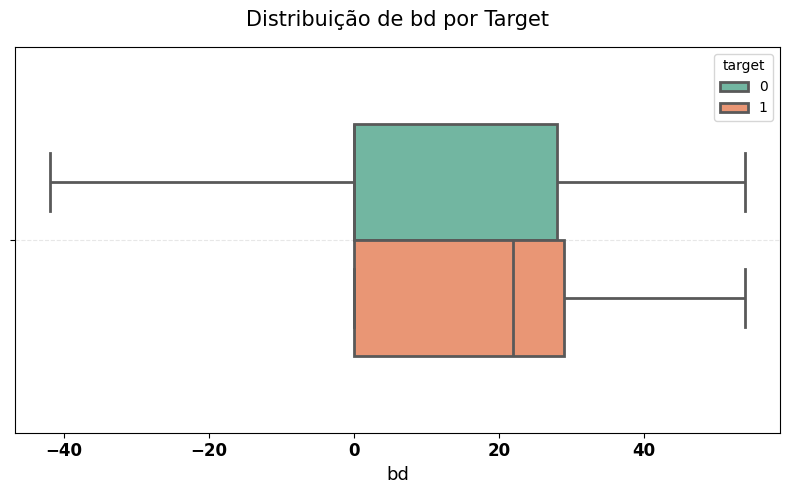

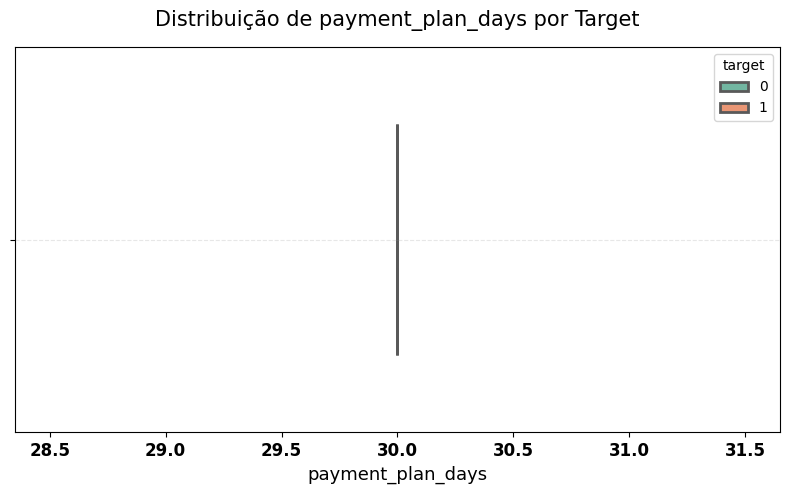

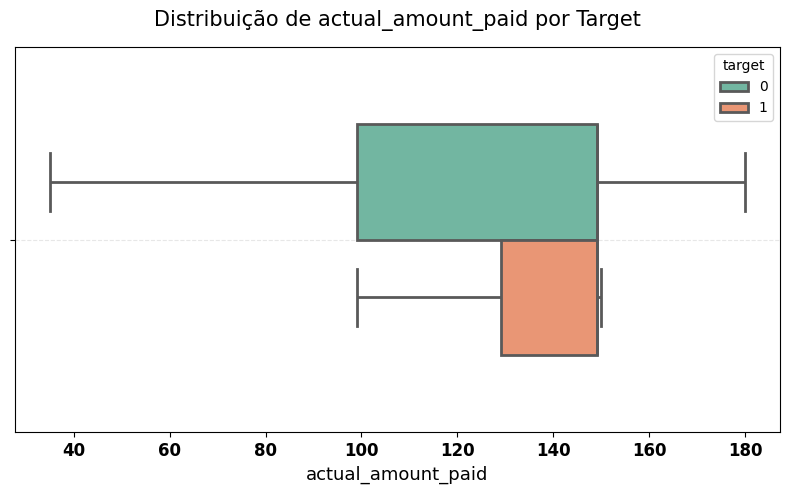

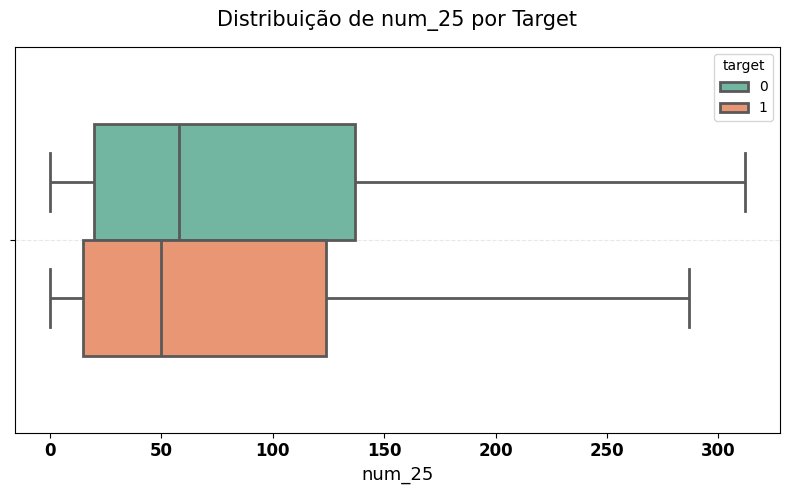

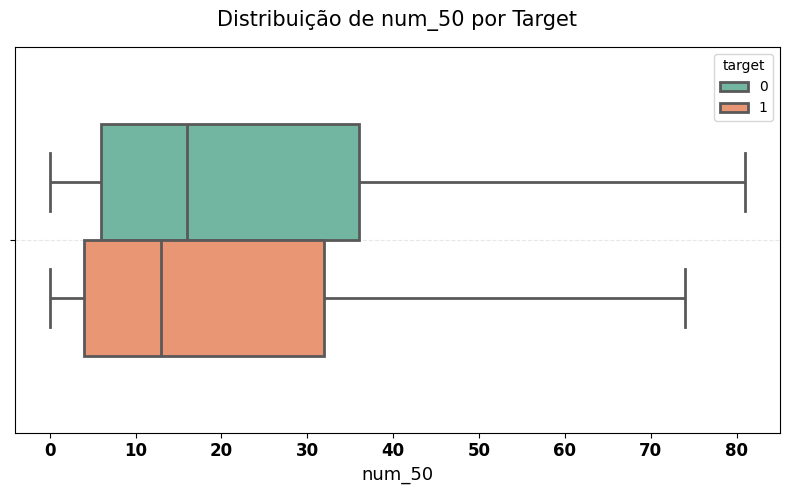

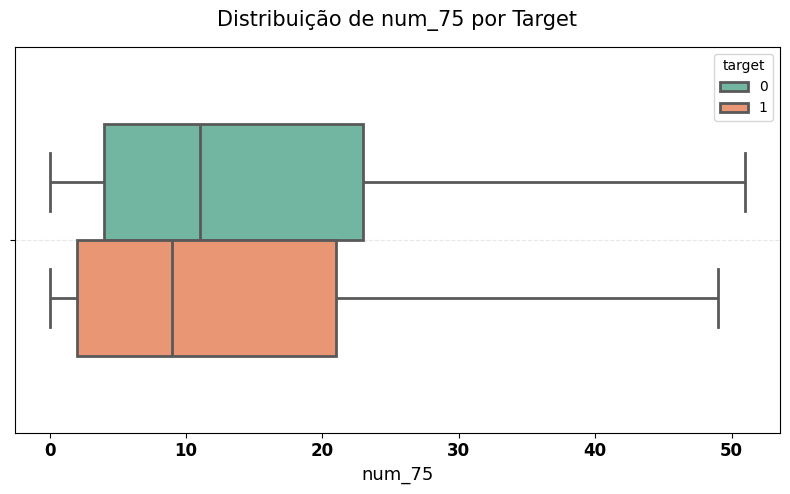

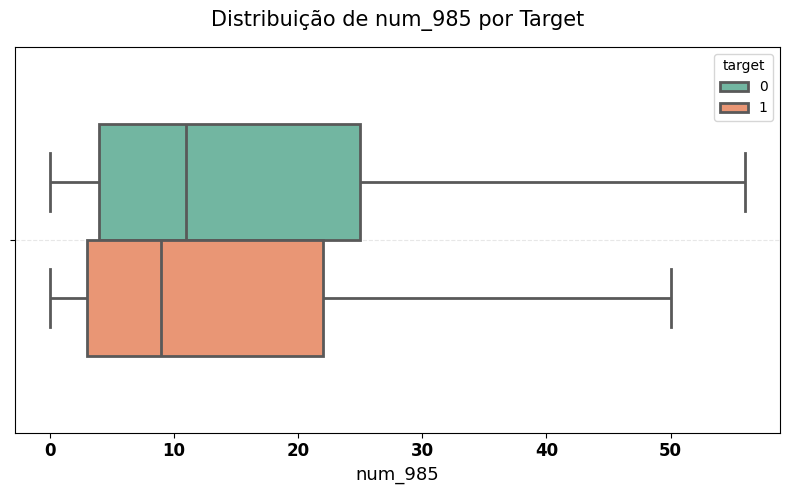

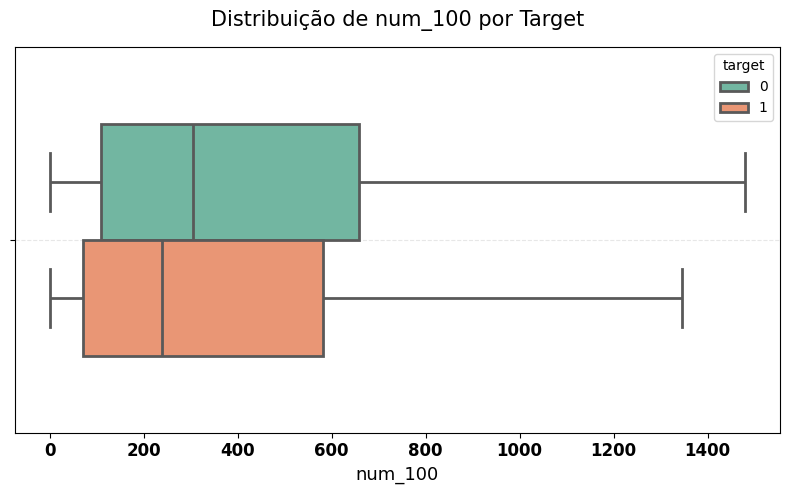

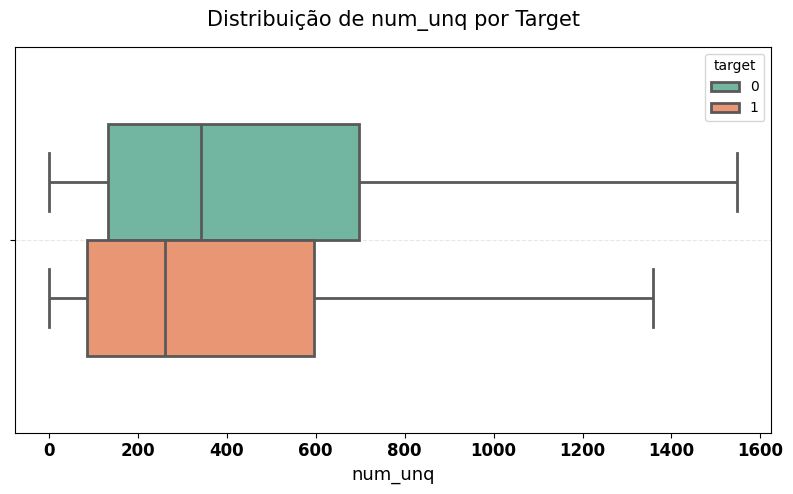

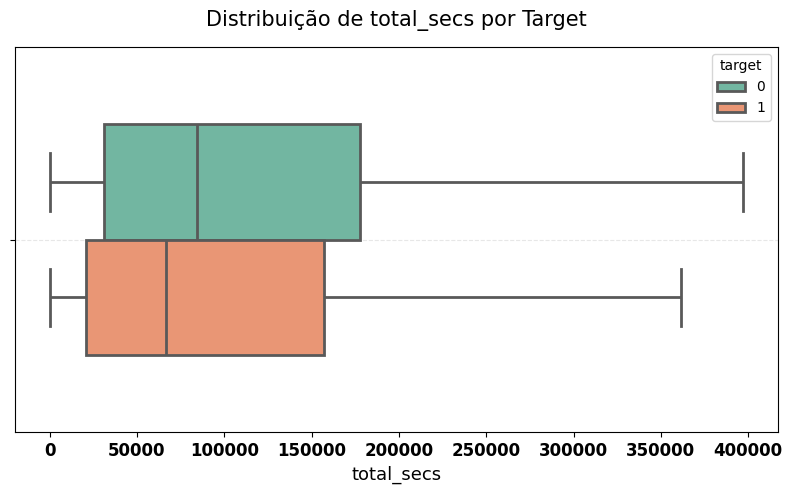

In [21]:
for i in num_cols:
  plt.figure(figsize=(8, 5))  # Ajusta o tamanho
  p99 = train[i].quantile(0.99)
  p1 = train[i].quantile(0.01)
  df_plot = train[(train[i] <= p99)]# & (train['bd'] >= p1)]
  sns.boxplot(data=df_plot,hue='target',x=i,orient='h',palette='Set2',showfliers=False, linewidth=2,width=0.6)
  plt.title(f'Distribuição de {i} por Target', fontsize=15, pad=15)
  plt.xlabel(i, fontsize=13)
  plt.grid(axis='y', linestyle='--', alpha=0.3)
  plt.tight_layout()
  plt.xticks(fontsize=12, weight='bold')
  plt.show()

## Criação de novas features
- tempo_expiracao : utilizar os tempo da safra atual até a data de expiracao do plano. Para os valores nulos, utiliza-se o valor médio do tempo de expiracao. 
- tempo_iniciacao : tempo desde que se tornou membro pela primeira vez
- Estatistica dos minutos escutados nos utimos meses, mostrando uma tendencia dos dados históricos do perfil de musicas escutadas pelo cliente. 

In [ ]:
import datetime as dt

train['tempo_expiracao'] = (pd.to_datetime(train['membership_expire_date']) - pd.to_datetime(train['safra'])).dt.days
train['tempo_iniciacao'] = (pd.to_datetime(train['safra']) - pd.to_datetime(train['registration_init_time'])).dt.days
test['tempo_expiracao'] = (pd.to_datetime(test['membership_expire_date']) - pd.to_datetime(test['safra'])).dt.days
test['tempo_iniciacao'] = (pd.to_datetime(test['safra']) - pd.to_datetime(test['registration_init_time'])).dt.days
valid['tempo_expiracao'] = (pd.to_datetime(valid['membership_expire_date']) - pd.to_datetime(valid['safra'])).dt.days
valid['tempo_iniciacao'] = (pd.to_datetime(valid['safra']) - pd.to_datetime(valid['registration_init_time'])).dt.days
oot['tempo_expiracao'] = (pd.to_datetime(oot['membership_expire_date']) - pd.to_datetime(oot['safra'])).dt.days
oot['tempo_iniciacao'] = (pd.to_datetime(oot['safra']) - pd.to_datetime(oot['registration_init_time'])).dt.days

In [ ]:
train[['tempo_expiracao', 'tempo_iniciacao']].describe(percentiles=[0.01,0.025, 0.1, 0.2, 0.3, 0.4, 0.5,0.6, 0.7, 0.8, 0.9, 0.95, 0.98 ,0.99])

# Pré-processamento

### **Tratamento dos nulos**

**Transações**

Para as colunas provenientes da base de transações, assume-se que os valores nulos são provenientes de cliente com plano com renovação maior que um mês. Nesse caso o cliente não realizou transferencia no mes, mas continua ativo (membership_expire_date > safra). 

Utiliza-se entao, os valores medios das transacoes com payment_plan_days maior que 30 dias para as colunas payment_plan_days, actual_amount_paid, is_auto_renew

In [ ]:
transacoes = df_transactions.filter((F.col('payment_plan_days')> 30)&(F.col('safra')<='2016-08-01'))

In [ ]:
ids = train[train['payment_plan_days'].isnull()]['msno'].unique().tolist()

In [ ]:
transacoes = transacoes.filter(F.col('msno').isin(ids))

In [ ]:
payment_plan_days = transacoes.agg(F.mean('payment_plan_days')).collect()[0][0]
plan_list_price = transacoes.agg(F.mean('plan_list_price')).collect()[0][0]
actual_amount_paid = transacoes.agg(F.mean('actual_amount_paid')).collect()[0][0]
train['payment_plan_days'] = train['payment_plan_days'].fillna(payment_plan_days)
train['plan_list_price'] = train['plan_list_price'].fillna(plan_list_price)
train['actual_amount_paid'] = train['actual_amount_paid'].fillna(actual_amount_paid)
test['payment_plan_days'] = test['payment_plan_days'].fillna(payment_plan_days)
test['plan_list_price'] = test['plan_list_price'].fillna(plan_list_price)
test['actual_amount_paid'] = test['actual_amount_paid'].fillna(actual_amount_paid)
valid['payment_plan_days'] = valid['payment_plan_days'].fillna(payment_plan_days)
valid['plan_list_price'] = valid['plan_list_price'].fillna(plan_list_price)
valid['actual_amount_paid'] = valid['actual_amount_paid'].fillna(actual_amount_paid)
oot['payment_plan_days'] = oot['payment_plan_days'].fillna(payment_plan_days)
oot['plan_list_price'] = oot['plan_list_price'].fillna(plan_list_price)
oot['actual_amount_paid'] = oot['actual_amount_paid'].fillna(actual_amount_paid)

**Váriáveis categóricas**

Para as variaveis categóricas, opta-se por criar uma nova categoria 'sem_registro'

In [ ]:
for col in cat_cols:
    train[col] = train[col].fillna('sem_registro')
    test[col] = test[col].fillna('sem_registro')
    valid[col] = valid[col].fillna('sem_registro')
    oot[col] = oot[col].fillna('sem_registro')

**Variáveis numéricas**

In [ ]:
num_cols.append('tempo_expiracao')
num_cols.append('tempo_iniciacao')
for col in num_cols:
    train[col] = train[col].astype('float64')
    test[col] = test[col].astype('float64')
    valid[col] = valid[col].astype('float64')
    oot[col] = oot[col].astype('float64')
    mean = train[col].mean()
    train[col] = train[col].fillna(mean)
    test[col] = test[col].fillna(mean)
    valid[col] = valid[col].fillna(mean)
    oot[col] = oot[col].fillna(mean)

### **Tratamento de outliers**

Observa-se que algumas variaveis numericas possuem outliers, e então decide-se utilizar como maximo o percentile 0.99 e como minimo o percentile 0.01. 

A variavel bd, que representa a idade do cliente membro, apresenta alguns valores maiores que 100 anos possui e muitos valores iguais ou menores que zero, algo que não faz sentido. Desta forma, separa-se apenas os valores maior que zero e até 100, e entao utiliza-se o percentile 0.01 e 0.99 dessa amostra, para servirem como minimos e maximos para essa variavel.

Para o tempo de iniciação, foram observados alguns valores negativos, desta forma, usa-se como piso o valor do percentile 0.025. 

In [ ]:
aux = train[(train['bd']>0)&(train['bd']<100)]
p1 = aux['bd'].quantile(0.01)
p99 = aux['bd'].quantile(0.99)
train['bd'] = np.where(train['bd'] < p1, p1, train['bd'])
train['bd'] = np.where(train['bd'] > p99, p99, train['bd'])
test['bd'] = np.where(test['bd'] < p1, p1, test['bd'])
test['bd'] = np.where(test['bd'] > p99, p99, test['bd'])
valid['bd'] = np.where(valid['bd'] < p1, p1, valid['bd'])
valid['bd'] = np.where(valid['bd'] > p99, p99, valid['bd'])
oot['bd'] = np.where(oot['bd'] < p1, p1, oot['bd'])
oot['bd'] = np.where(oot['bd'] > p99, p99, oot['bd'])

In [ ]:
for i in num_cols:
    if i == 'bd':
        pass
    if i == 'tempo_iniciacao':
        p99 = train[i].quantile(0.99)
        p025 = train[i].quantile(0.025)
        train[i] = train[i].clip(lower=p025, upper=p99, axis=0)
        test[i] = test[i].clip(lower=p025, upper=p99, axis=0)
        valid[i] = valid[i].clip(lower=p025, upper=p99, axis=0)
        oot[i] = oot[i].clip(lower=p025, upper=p99, axis=0)
    p99 = train[i].quantile(0.99)
    p1 = train[i].quantile(0.01)
    train[i] = train[i].clip(lower=p1, upper=p99, axis=0)
    test[i] = test[i].clip(lower=p1, upper=p99, axis=0)
    valid[i] = valid[i].clip(lower=p1, upper=p99, axis=0)
    oot[i] = oot[i].clip(lower=p1, upper=p99, axis=0)

In [ ]:
# Retirando colunas que não serão utilizadas
drop_cols = ['chave', 'registration_init_time','membership_expire_date', 'is_ativo', 'safra_target']
df_train = train.drop(columns=drop_cols)
df_test = test.drop(columns=drop_cols)
df_valid = valid.drop(columns=drop_cols)
df_oot = oot.drop(columns=drop_cols)

In [ ]:
# Salvando os DataFrames em arquivos CSV
df_train.to_csv("dados/train.csv", index=False)
df_test.to_csv("dados/test.csv", index=False)
df_valid.to_csv("dados/valid.csv", index=False)
df_oot.to_csv("dados/oot.csv", index=False)

# **Feature Selection**

Para a seleção das features, foi realizada uma analise de feature importance utilizando Random Forest, determinando a quantidade otima de features com RFECV, que realiza uma validação cruzada com folds estratificadas, a fim de manter a proporção das classes da target, e itertivamente retira features uma a uma, comparando a performance dos modelos com cada conjunto de features. 

In [28]:
train = pd.read_csv("../dados/train.csv")
test = pd.read_csv("../dados/test.csv")
valid = pd.read_csv("../dados/valid.csv")
oot = pd.read_csv("../dados/oot.csv")

In [ ]:
cat_cols = ['city', 'gender', 'registered_via','is_auto_renew', 'is_cancel']
num_cols = ['bd', 'payment_plan_days', 'plan_list_price', 'actual_amount_paid', 
            'num_25', 'num_50', 'num_75', 'num_985', 'num_100', 'num_unq', 'total_secs', 
            'tempo_expiracao', 'tempo_iniciacao']
for i in cat_cols:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')
    valid[i] = valid[i].astype('category')
    oot[i] = oot[i].astype('category')
for i in num_cols:
    train[i] = train[i].astype('float64')
    test[i] = test[i].astype('float64')
    valid[i] = valid[i].astype('float64')
    oot[i] = oot[i].astype('float64')


In [33]:
# target encoding para as variaveis categóricas 

def target_encode(train, test, valid, oot, cat_cols, target_col):
    for col in cat_cols:
        # Calcula a média do target para cada categoria
        mean_target = train.groupby(col)[target_col].mean().to_dict()

        # Mapeia a média do target para cada categoria no conjunto de treino
        train[col] = train[col].map(mean_target)
        test[col] = test[col].map(mean_target)
        valid[col] = valid[col].map(mean_target)
        oot[col] = oot[col].map(mean_target)
        
        # Converte a coluna de target encoding para float64
        train[col] = train[col].astype('float64')
        test[col] = test[col].astype('float64')
        valid[col] = valid[col].astype('float64')
        oot[col] = oot[col].astype('float64')
    return train, test, valid, oot
train, test, valid, oot = target_encode(train, test, valid, oot, cat_cols, 'target')

In [36]:
X_train = train[cat_cols + num_cols]
y_train = train['target']
X_test = test[cat_cols + num_cols]
y_test = test['target']
X_valid = valid[cat_cols + num_cols]
y_valid = valid['target']
X_oot = oot[cat_cols + num_cols]
y_oot = oot['target']


In [40]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.feature_selection import RFECV
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# import numpy as np
# import pandas as pd

# # Pré-processamento
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False, min_frequency=5), cat_cols),  # min_frequency filtra colunas raras
#         ('num', 'passthrough', num_cols)
#     ]
# )
# X_train_enc = preprocessor.fit_transform(X_train)
# feature_names = np.concatenate([
#     preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols),
#     num_cols
# ])

# # Parâmetros otimizados do modelo
# rf_params = dict(
#     n_estimators=50,      # Menos árvores
#     max_depth=5,          # Árvores mais rasas
#     random_state=42,
#     n_jobs=-1,
#     class_weight='balanced'
# )
# rf = RandomForestClassifier(**rf_params)

# # RFECV mais leve
# skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# rfecv = RFECV(
#     estimator=rf,
#     step=3,
#     cv=skf,
#     scoring='f1',
#     n_jobs=-1,
#     min_features_to_select=5  # Mantém pelo menos 5 features (opcional)
# )
# rfecv.fit(X_train_enc, y_train)

# print(f"Número ótimo de features: {rfecv.n_features_}")

# # Features selecionadas pelo threshold do RFECV
# selected_features = feature_names[rfecv.support_]
# print("Features selecionadas:", selected_features)

# # Importância das features selecionadas
# importances = rfecv.estimator_.feature_importances_
# feat_imp = pd.DataFrame({
#     'feature': selected_features,
#     'importance': importances
# }).sort_values(by='importance', ascending=False)
# print(feat_imp)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np

# Parâmetros do modelo
rf_params = dict(
    n_estimators=50,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# Features (já numéricas, incluindo as target-encoded)
feature_names = X_train.columns.tolist()

# Stratified KFold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
importances = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Ajusta o modelo diretamente nos dados já numéricos
    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_tr, y_tr)
    importances.append(rf.feature_importances_)

# Importância média
importances = np.array(importances)
mean_importances = importances.mean(axis=0)

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_importances
}).sort_values(by='importance', ascending=False)

print(feat_imp)

# # Seleção das TOP N
# N = 15
# top_features = feat_imp.head(N)['feature'].tolist()
# print("\nTop features (cross-validated):", top_features)
# Defina o seu threshold (por exemplo, 0.01)

threshold = 0.01

# Selecionar features acima do threshold
top_features = feat_imp[feat_imp['importance'] > threshold]['feature'].tolist()
print(f"Features selecionadas (importância > {threshold}):", top_features)
# Aplicando seleção de features nas outras bases:
X_train_sel = X_train[top_features]
X_val_sel = X_val[top_features]
X_test_sel = X_test[top_features]
X_oot_sel = X_oot[top_features]


               feature  importance
3        is_auto_renew    0.312958
2       registered_via    0.146574
16     tempo_expiracao    0.139887
4            is_cancel    0.132866
8   actual_amount_paid    0.093298
7      plan_list_price    0.091804
6    payment_plan_days    0.026492
15          total_secs    0.016538
17     tempo_iniciacao    0.008928
14             num_unq    0.006984
0                 city    0.004859
5                   bd    0.004671
11              num_75    0.004078
1               gender    0.002911
10              num_50    0.002564
13             num_100    0.001824
9               num_25    0.001530
12             num_985    0.001233
Features selecionadas (importância > 0.01): ['is_auto_renew', 'registered_via', 'tempo_expiracao', 'is_cancel', 'actual_amount_paid', 'plan_list_price', 'payment_plan_days', 'total_secs']


In [41]:
# Salvando as bases processadas e selecionadas
X_train_sel.to_csv("../dados/X_train_sel.csv", index=False)
X_val_sel.to_csv("../dados/X_val_sel.csv", index=False)
X_test_sel.to_csv("../dados/X_test_sel.csv", index=False)
X_oot_sel.to_csv("../dados/X_oot_sel.csv", index=False)
# Salvando os alvos
y_train.to_csv("../dados/y_train.csv", index=False)
y_val.to_csv("../dados/y_val.csv", index=False)
y_test.to_csv("../dados/y_test.csv", index=False)
y_oot.to_csv("../dados/y_oot.csv", index=False)

# Modelo
* Avaliação de dois algoritmos para realizar a classificação binária: XGBoost e regressão logística
*

In [42]:
X_train = pd.read_csv("../dados/X_train_sel.csv")
X_val = pd.read_csv("../dados/X_val_sel.csv")
X_test = pd.read_csv("../dados/X_test_sel.csv")
X_oot = pd.read_csv("../dados/X_oot_sel.csv")
y_train = pd.read_csv("../dados/y_train.csv")
y_val = pd.read_csv("../dados/y_val.csv")
y_test = pd.read_csv("../dados/y_test.csv")
y_oot = pd.read_csv("../dados/y_oot.csv")

In [43]:
X_train.head()

,is_auto_renew,registered_via,tempo_expiracao,is_cancel,actual_amount_paid,plan_list_price,payment_plan_days,total_secs
0,0.268951,0.206644,49.479321,0.268951,980.842584,981.648114,232.823505,3.072952e+04
1,0.317512,0.206644,51.000000,0.072006,180.000000,180.000000,30.000000,3.696703e+04
2,0.043275,0.040787,37.000000,0.072006,99.000000,99.000000,30.000000,-4.786276e+10
3,0.043275,0.155276,61.000000,0.072006,0.000000,149.000000,30.000000,-4.786276e+10
4,0.043275,0.040787,49.000000,0.072006,99.000000,99.000000,30.000000,3.268110e+04


## Escolha do algorimo 

Para escolher o algoritmo que será utilizado na criação do modelo de classificação, testa-se 3 algoritmos diferentes, regressão logística, RandomForest e XGBoost, de forma rápida, a fim de comparar as performances e selecionar o algoritmo. 

Desta forma, cria-se um pipeline de pre-processamento e modelagem simples para cada algoritmo, e então coleta-se metricas de performance do modelo para a decisão. 

In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report

# Supondo que X_train, X_test já têm todas as variáveis numéricas (inclusive target-encoded)
num_cols = X_train.columns.tolist()  # já são todas numéricas

class_weight = {0: 1, 1: 10}

# Preprocessing pipelines (só padronização, se quiser)
preprocessors = {
    "logreg": StandardScaler(),   # útil para regressão logística
    "rf": 'passthrough',          # Random Forest não precisa
    "xgb": 'passthrough',         # XGBoost também não precisa
}

# Modelos ajustados com balanceamento e hiperparâmetros relevantes
models = {
    "logreg": LogisticRegression(
        max_iter=500, 
        class_weight=class_weight,  
        C=0.5
    ),
    "rf": RandomForestClassifier(
        n_estimators=200,
        max_depth=6,
        min_samples_leaf=5,
        min_samples_split=10,
        n_jobs=-1,
        random_state=42,
        class_weight=class_weight
    ),
    "xgb": xgb.XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=class_weight[1],  # XGBoost espera só o peso da classe positiva!
        n_jobs=-1,
        random_state=42,
        use_label_encoder=False,
        eval_metric='logloss'
    )
}

# Pipeline + avaliação rápida
for name in models:
    pipe = Pipeline([
        ('pre', preprocessors[name]),
        ('clf', models[name])
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1]
    print(f"\n=== {name.upper()} ===")
    print("AUC:", roc_auc_score(y_test, y_proba))
    print(classification_report(y_test, y_pred, digits=3))


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



=== LOGREG ===
AUC: 0.8513487072364069
              precision    recall  f1-score   support

           0      0.975     0.769     0.860    158988
           1      0.324     0.848     0.469     20774

    accuracy                          0.778    179762
   macro avg      0.649     0.809     0.664    179762
weighted avg      0.900     0.778     0.815    179762



/anaconda/envs/azureml_py38/lib/python3.10/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



=== RF ===
AUC: 0.8687023497475872
              precision    recall  f1-score   support

           0      0.975     0.771     0.861    158988
           1      0.326     0.848     0.471     20774

    accuracy                          0.780    179762
   macro avg      0.651     0.810     0.666    179762
weighted avg      0.900     0.780     0.816    179762



/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



=== XGB ===
AUC: 0.8731623629074092
              precision    recall  f1-score   support

           0      0.977     0.765     0.858    158988
           1      0.324     0.865     0.472     20774

    accuracy                          0.776    179762
   macro avg      0.651     0.815     0.665    179762
weighted avg      0.902     0.776     0.813    179762



**Modelo Classificação Binaria**

Como visto nos testes iniciais, o algoritmo que apresentou uma melhor performance foi o XGBoost. Desta forma, segue-se para a modelagem utilizando esse algoritmo. 

In [51]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, log_loss
)

def get_binary_classification_metrics(y_true, y_pred, y_pred_proba=None):
    """
    Retorna um DataFrame pandas com as principais métricas de avaliação para classificação binária.

    Parâmetros:
    - y_true: array-like, rótulos verdadeiros
    - y_pred: array-like, predições do modelo (0 ou 1)
    - y_pred_proba: array-like, probabilidades da classe positiva (opcional, recomendado)

    Retorno:
    - metrics_df: pandas.DataFrame com as métricas
    """

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, zero_division=0),
        'recall': recall_score(y_true, y_pred, zero_division=0),
        'f1_score': f1_score(y_true, y_pred, zero_division=0)
    }
    metrics['roc_auc'] = roc_auc_score(y_true, y_pred_proba)
    metrics['pr_auc'] = average_precision_score(y_true, y_pred_proba)
    metrics['log_loss'] = log_loss(y_true, y_pred_proba)

    # Matriz de confusão (TP, FP, TN, FN)
    cm = confusion_matrix(y_true, y_pred)
    metrics['tn'] = cm[0, 0]
    metrics['fp'] = cm[0, 1]
    metrics['fn'] = cm[1, 0]
    metrics['tp'] = cm[1, 1]

    # Retorna em DataFrame para fácil visualização
    metrics_df = pd.DataFrame([metrics])
    return metrics_df


In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, classification_report
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Espaço de busca de hiperparâmetros
space = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(50, 300)),
    'gamma': hp.uniform('gamma', 0, 5),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1)
}

def objective(params):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx].copy(), X_train.iloc[val_idx].copy()
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # XGBoost com hiperparâmetros
        model = xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss',
            **params
        )
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        f1 = f1_score(y_val, preds)
        f1_scores.append(f1)
    
    mean_f1 = np.mean(f1_scores)
    return {'loss': -mean_f1, 'status': STATUS_OK}

trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=30,
    trials=trials,
    rstate=np.random.default_rng(42)  
)

print("Melhores hiperparâmetros encontrados:", best)

# Recuperando os hiperparâmetros reais
best_params = {
    'max_depth': range(3, 10)[best['max_depth']],
    'learning_rate': best['learning_rate'],
    'n_estimators': range(50, 300)[best['n_estimators']],
    'gamma': best['gamma'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_alpha': best['reg_alpha'],
    'reg_lambda': best['reg_lambda']
}

# Treinando modelo final
final_model = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    **best_params
)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

print("\n--- Avaliação final no conjunto de teste ---")
print("AUC:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))


  0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Inde

  3%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 1/30 [02:31<1:13:12, 151.47s/trial, best loss: -0.36640226389140895]

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Inde

  3%|██████████████████████████████▊                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             | 1/30 [04:42<2:16:26, 282.29s/trial, best loss: -0.36640226389140895]


KeyboardInterrupt: 

# Análise não supervisionada 